In [1]:
import json
import torch
import pytorch_lightning as pl
from src.data.covid_dataset import CovidDataModule
from src.models.hardnet_base import HarDNet
from src.models.FCHardnet import FCHardnet
from monai.networks.nets import DenseNet121
from matplotlib import pyplot as plt
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.data import decollate_batch, DataLoader
import os
import shutil
import tempfile
import PIL
import numpy as np

In [2]:
data_dir = os.path.join("src", "data", "MedNIST")
class_names = sorted(
    x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))
)
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)

In [3]:
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


In [4]:
val_frac = 0.1
test_frac = 0.1
length = len(image_files_list)
indices = np.arange(length)
np.random.shuffle(indices)

test_split = int(test_frac * length)
val_split = int(val_frac * length) + test_split
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

train_x = [image_files_list[i] for i in train_indices]
train_y = [image_class[i] for i in train_indices]
val_x = [image_files_list[i] for i in val_indices]
val_y = [image_class[i] for i in val_indices]
test_x = [image_files_list[i] for i in test_indices]
test_y = [image_class[i] for i in test_indices]

print(
    f"Training count: {len(train_x)}, Validation count: "
    f"{len(val_x)}, Test count: {len(test_x)}"
)

Training count: 47164, Validation count: 5895, Test count: 5895


In [5]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()]
)

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_class)])

In [6]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = DataLoader(val_ds, batch_size=20)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = DataLoader(test_ds, batch_size=20)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = HarDNet(depth_wise=False, arch=39, out_channels=num_class).to(device)

In [13]:
from monai.metrics import ROCAUCMetric

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
max_epochs = 3
val_interval = 1
auc_metric = ROCAUCMetric()

In [14]:
from torch.utils.tensorboard import SummaryWriter

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}"
        )
        epoch_len = len(train_ds) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)
print(
    f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}"
)
writer.close()

----------
epoch 1/3


1/2358, train_loss: 1.7375
2/2358, train_loss: 1.8824
3/2358, train_loss: 1.7662
4/2358, train_loss: 1.8010
5/2358, train_loss: 1.6556
6/2358, train_loss: 1.5342
7/2358, train_loss: 1.7387
8/2358, train_loss: 1.5878
9/2358, train_loss: 1.4886
10/2358, train_loss: 1.5653
11/2358, train_loss: 1.4070
12/2358, train_loss: 1.4724
13/2358, train_loss: 1.5143
14/2358, train_loss: 1.3714
15/2358, train_loss: 1.3705
16/2358, train_loss: 1.2905
17/2358, train_loss: 1.3535
18/2358, train_loss: 1.3350
19/2358, train_loss: 1.0629
20/2358, train_loss: 1.2098
21/2358, train_loss: 1.4054
22/2358, train_loss: 1.1637
23/2358, train_loss: 1.1146
24/2358, train_loss: 1.0985
25/2358, train_loss: 1.1395
26/2358, train_loss: 1.4794
27/2358, train_loss: 1.2502
28/2358, train_loss: 1.0496
29/2358, train_loss: 0.9840
30/2358, train_loss: 1.0745
31/2358, train_loss: 1.0581
32/2358, train_loss: 1.0026
33/2358, train_loss: 1.0956
34/2358, train_loss: 1.0019
35/2358, train_loss: 1.2394
36/2358, train_loss: 1.1278
3

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

with open(f".\src\data\covid_dataset.json", "r") as file:
    data = json.load(file)

# datamodule = ISLESDataModule(data_properties=data, batch_size=1, device=device)
datamodule = CovidDataModule(batch_size=8, device=device, data_properties=data)

d:\Conda\envs\hardnet\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [3]:
datamodule.setup()

In [5]:
train_loader = datamodule.val_dataloader()
for batch_idx, batch in enumerate(train_loader):
    print(batch["label"][0].shape)

Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
torch.Size([1, 128, 128])
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 2
Triet's log - user provide: (128, 128)
Triet's log - ndim: 

----------------0-----------------
torch.Size([128, 128])


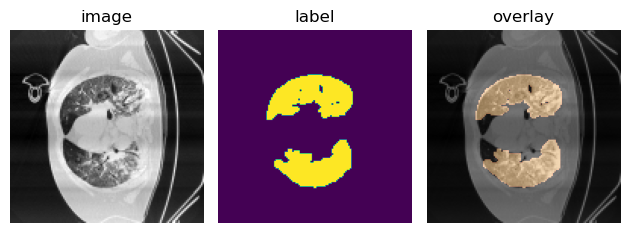

----------------1-----------------
torch.Size([128, 128])


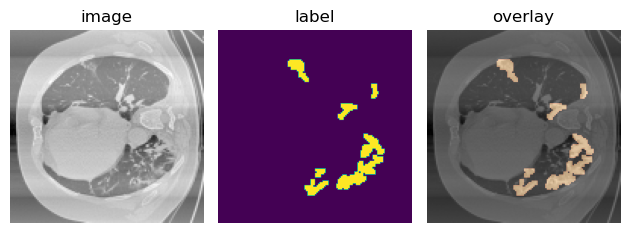

----------------2-----------------
torch.Size([128, 128])


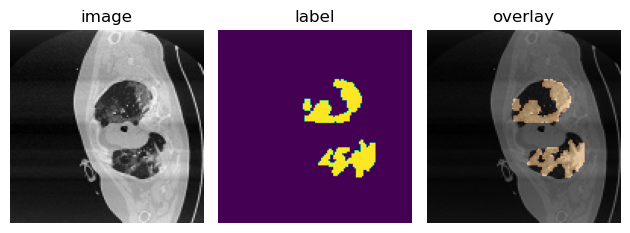

----------------3-----------------
torch.Size([128, 128])


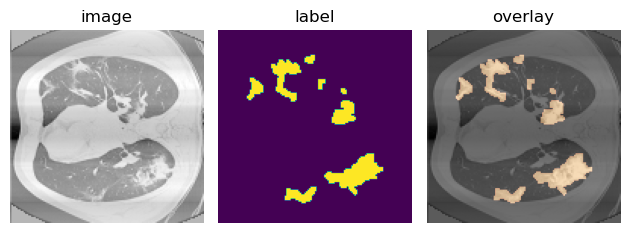

----------------4-----------------
torch.Size([128, 128])


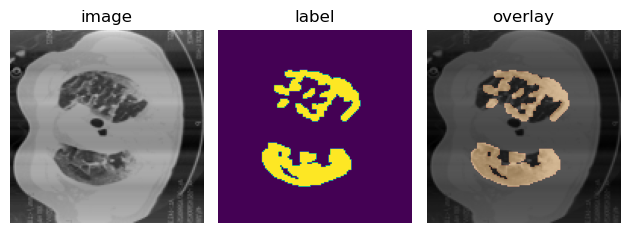

----------------5-----------------
torch.Size([128, 128])


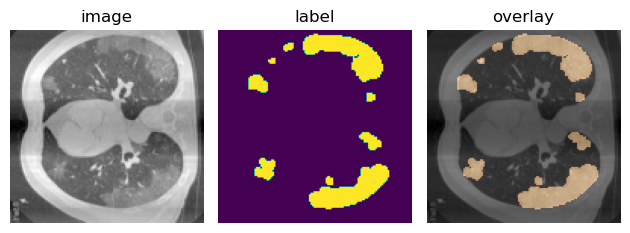

In [8]:
for batch_idx, batch in enumerate(train_loader):
    if batch_idx < 6:
        print(f"----------------{batch_idx}-----------------")
        print(batch["image"][0].shape)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        ax1.imshow(batch["image"][0][:, :].detach().cpu(), cmap="gray")
        ax1.set_title("image")
        ax1.set_axis_off()

        ax2.imshow(batch["label"][0][:, :].detach().cpu())
        ax2.set_title("label")
        ax2.set_axis_off()

        ax3.imshow(batch["image"][0][:, :].detach().cpu(), cmap="gray")
        ax3.imshow(batch["label"][0][:, :].detach().cpu(), alpha=0.5, cmap="copper")
        ax3.set_title("overlay")
        ax3.set_axis_off()
        plt.tight_layout()
        plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with open(f".\src\data\covid_dataset.json", "r") as file:
    data = json.load(file)

# datamodule = ISLESDataModule(data_properties=data, batch_size=1, device=device)
datamodule = CovidDataModule(
    batch_size=10, device=device, data_properties=data
)

In [12]:
    # # Total image to read in. In this case, it's 10 (for both train and val). With split = 0.7, 7 wll go to train and 3 will go to val
datamodule.setup()

# #Loadin the data according to the upper parameters
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()

In [13]:
from monai.losses import DiceCELoss
model = FCHardnet(n_classes=1, in_channels=1).to(device)

In [19]:
loss_function = DiceCELoss(sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 0.001)
max_epochs = 3
val_interval = 1

In [9]:
train_ds = datamodule.train_set

In [7]:
for batch_data in train_loader:
    print(batch_data['image'].shape)
    print(batch_data['label'].shape)
    break

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


In [20]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, masked = batch_data['image'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        print(outputs.shape)
        loss = loss_function(outputs, masked)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}"
        )
        epoch_len = len(train_ds) // train_loader.batch_size
    #     writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/3
torch.Size([10, 1, 128, 128])
1/13, train_loss: 1.4797
torch.Size([10, 1, 128, 128])
2/13, train_loss: 1.5864
torch.Size([10, 1, 128, 128])
3/13, train_loss: 1.4366
torch.Size([10, 1, 128, 128])
4/13, train_loss: 1.5228
torch.Size([10, 1, 128, 128])
5/13, train_loss: 1.3641
torch.Size([10, 1, 128, 128])
6/13, train_loss: 1.2289
torch.Size([10, 1, 128, 128])
7/13, train_loss: 1.3086
torch.Size([10, 1, 128, 128])
8/13, train_loss: 1.3478
torch.Size([10, 1, 128, 128])
9/13, train_loss: 1.4634
torch.Size([10, 1, 128, 128])
10/13, train_loss: 1.3767
torch.Size([10, 1, 128, 128])
11/13, train_loss: 1.3932
torch.Size([10, 1, 128, 128])
12/13, train_loss: 1.3847
torch.Size([10, 1, 128, 128])
13/13, train_loss: 1.3446
torch.Size([5, 1, 128, 128])
14/13, train_loss: 1.3612
epoch 1 average loss: 1.3999
----------
epoch 2/3
torch.Size([10, 1, 128, 128])
1/13, train_loss: 1.1877
torch.Size([10, 1, 128, 128])
2/13, train_loss: 1.2191
torch.Size([10, 1, 128, 128])
3/13, train_los